# Manifold Learning and Dimensionality Reduction: Linear approaches

In many biomedical applications we will be faced with datasets that are represented with high dimensional featuresets but relatively few examples. This increases the chances of overfitting as, in ever higher dimensions, the same amount of data fills the featurespace more and more sparsely. Specifically, if we divide a region of space into regular cells we can see that the number of such cells grows exponentially with the dimensionality of the space [1]:

<img src="imgs/curseofdimensionality.png" style="max-width:100%; width: 50%; max-width: none">

The problem with an exponentially large number of cells is that we would need an exponentially large quantity of training data in order to ensure that the cells are not empty. Without this the chance of finding a separating hyperplane by chance becomes easier, and we become prone to overfitting.  What we need therefore is some way of reducing the featurespace such that the number of features does not significanlty exceed that of the number of data examples. This can be done in a number of ways: feature selection (which you will learn about in future lectures) and manifold learning, which we describe here. 

Manifold Learning describes a family of methods that seek to map the data into a lower dimensional space by exploiting the underlying geometry of the data.  Typically this is made possible because real world data are subject to physical laws and thus have limited degrees of freedom. This tends to mean that data generated by real world processes live on a low dimensional manifold, embedded within the high dimensional feature space. To explain what this means we can use a fairly artificial example: the 'Swiss roll model:' 

<img src="imgs/swissrollmodel.png" style="max-width:100%; width: 75%; max-width: none">

Here it is clear that whilst the data lives in three dimensions, the geometry of the data is better represented in two (the result of unrolling the embedded representation). This underlying geometry can be determined by exploiting the local neighbourhood structure of the data. In this way it can be shown that the euclidean distance between two different points on the roll in three dimensions can vastly mispresent the true distance along the underlying manifold.

Thus, manifold learning techniques are designed to map the data to a new space that better represents the underlying geometry of the data, in this way enabling the use of simpler learning methods that can more sensitivitely cluster or classify the underlying data. Many different methods for manifold learning exist and these can be split into linear methods (that seek to find a sub-space of the data through linearly transforming the data) and non-linear approaches that more successully utlise the local neighbourhood structure of the data. In this lecture we will discuss linear approaches: specifically PCA and ICA. Next week will will introduce Laplacian Eigenmaps and Spectral clustering, which will allow learning of much more complex non-linear structures.

Importing generic modules used throughout the notebook:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from sklearn.decomposition import PCA

%matplotlib inline 

## 1. Linear Transforms

We start by discussing linear transforms as these form a core component of all methods in this lecture.

A linear transformation, $ T:\mathbb{R}^n \rightarrow \mathbb{R}^m$ , is a function which satisfies

1. $T(\mathbf{x_1} +\mathbf{x_2})=T(\mathbf{x_1})+ T(\mathbf{x_2}) \; \forall \mathbf{x_1}, \mathbf{x_2} \in \mathbb{R}^n $  (additivity)
2. $T(\alpha \mathbf{x_1})=\alpha T(\mathbf{x_1}) \; \forall \mathbf{x_1} \in \mathbb{R}^n ; \alpha \in  \mathbb{R} $ (scalar multiplicativy)
3. Preserves origin 	


The action of a matrix on a vector space is a linear transform 

i.e. consider the action of the matrix A=$\begin{pmatrix} 
3 & 0 \\ 0 & 1 \\ \end{pmatrix} $ on the vector $\begin{pmatrix} x \\ y \\ \end{pmatrix} $ 

$ \begin{pmatrix} x' \\  y'\\ \end{pmatrix}=\begin{pmatrix} 3 & 0 \\ 0 & 1 \\ \end{pmatrix} \begin{pmatrix} x \\ y\\ \end{pmatrix} = x \begin{pmatrix} 3 \\ 0\\ \end{pmatrix} + y \begin{pmatrix} 0 \\ 1\\ \end{pmatrix}$ 

Applied to a cluster of grid points we can clearly see this transform as a stretch in the x-axis:

<img src="imgs/gridtransform.png" style="max-width:100%; width: 75%; max-width: none">

This may be more clearly shown through the following matplotlib animation developed using code adapted from https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html
and https://notgnoshi.github.io/linear-transformations/

Note: you need ffmpeg installed for this to run. In Anaconda Prompt run

```conda install -c menpo ffmpeg```


In [3]:
import animate_transforms as an
from matplotlib import  rc

rc('animation', html='html5')


A = np.column_stack([[3, 0], [0, 1]])
anim = an.animate_transform(A, repeat=True)
anim

**Optional Exercise:** Try changing A to different matrix forms and experiment with the different linear transforms you can achieve. What types of transforms are these describing?

e.g. Try A=$\begin{pmatrix} 2 & 0.5 \\ 0.5 & 1 \\ \end{pmatrix} $,  A=$\begin{pmatrix} 1 & 2 \\ 0 & 1 \\ \end{pmatrix} $ and a rotation of the form  A=$\begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \\ \end{pmatrix} $

### Eigendecomposition

Eigendecomposition presents linear operators in a simplied, diagonalised form. Specifically, eigenvectors of linear transforms are (non-zero) vectors which remain unchanged (with exception of a scale factor) following application of the transform e.g (taken from [wikipedia](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)).

<img src="imgs/mona_lisa_example.png" style="max-width:100%; width: 50%; max-width: none">

Here, the blue vector represents an eigenvector as its direction remains unchanged by the application of a shear transform. On the other hand the red vector cannot be an eigenvector, since its direction is changed. Eigenvalues represent the scaling factor with with the magnitude of the eigenvector changes under the transformation.

Thus eigenvectors $\mathbf{v}$ of a matrix $\mathbf{A}$ obey the following equation:

$$\mathbf{A}\mathbf{v}=\lambda \mathbf{v}$$

and thus may be found by starting from the characteristic equation:

$$\mathbf{A} \mathbf{v}-\lambda \mathbf{v}=0$$
$$ \rightarrow (\mathbf{A}-\lambda \mathbf{I})\mathbf{v}=0$$
$$ \rightarrow |\mathbf{A}-\lambda \mathbf{I}|=0$$

Since we have already defined $\mathbf{v}$ to be non zero. Here $\mathbf{I}$ is the identity matrix. Note, the determinant ($ \det \mathbf{B}$ or $|\mathbf{B}|$) of a 2D matrix:

$$ \begin{pmatrix} 
a & b \\ 
d & c \\ 
\end{pmatrix} $$

is defined as:

$$ |\mathbf{B}|= ac-bd $$

Thus, for linear transform:

$$ \mathbf{A}= \begin{pmatrix} 
3 & 0 \\ 
0 & 1 \\ 
\end{pmatrix} $$

We estimate $|\mathbf{A}-\lambda \mathbf{I}|= 0 $ as:

$$ \rightarrow \begin{pmatrix} 
3-\lambda & 0 \\ 
0 & 1-\lambda \\ 
\end{pmatrix}=0 $$

$$ \rightarrow (3-\lambda)(1-\lambda)=0 $$.

Thus, $(3-\lambda)$ and $(1-\lambda)$ must equal zero, and the eigenvalues of this linear transform are 3 and 1. Accordingly estimating the eigenvector for $\lambda=3$ results from:

$$(\mathbf{A}-\lambda \mathbf{I})\mathbf{v}= 0 $$

$$ \begin{pmatrix} 
3-3 & 0 \\ 
0 & 1-3 \\ 
\end{pmatrix}  \begin{pmatrix} 
v_1  \\ 
v_2 \\ 
\end{pmatrix}=0  $$

$$ \rightarrow 0v_1 + 0v_2=0 $$ and 
$$ \rightarrow 0v_1 - 2v_2=0 $$

Which implies $v_2$ must be zero, since $2 \times v_2$ cannot equal $0$ unless $v_2=0$. However $|\mathbf v|$ is by definitiion non-zero, therefore the eigenvector corresponding to $\lambda=3$ (defined up to an arbitrary scale factor $k$) is:

$$\begin{pmatrix} 
k  \\ 
0 \\ 
\end{pmatrix}  $$

For PCA we will insist on eigenvectors of unit magnitude. Accordingly, the eigenvector we are looking for is 

$$\begin{pmatrix} 
1  \\ 
0 \\ 
\end{pmatrix}=0  $$

Next for $\lambda=1$:

$$ \begin{pmatrix} 
3-1 & 0 \\ 
0 & 1-1 \\ 
\end{pmatrix}  \begin{pmatrix} 
v_1  \\ 
v_2 \\ 
\end{pmatrix}=0  $$

$$ \rightarrow 2v_1 + 0v_2=0 $$ and 
$$ \rightarrow 0v_1 - 0v_2=0 $$

Again, this implies $v_1$ must be zero (from $2v_1=0$); thus the eigenvector corresponding to $\lambda=1$ is:

$$\begin{pmatrix} 
0  \\ 
k \\ 
\end{pmatrix}  $$

Therefore, the *unit* eigenvector corresponding to eigenvalue 1 is:

$$\begin{pmatrix} 
0  \\ 
1 \\ 
\end{pmatrix}
$$

Together these represent a stretch in the x axis with y axis unchanged.


### Eigenvectors of Symmetric Matrices

If instead we have a matrix with an off diagonal term, such as $\mathbf{A}_2=\left(\begin{smallmatrix}2 & 1 \\1 & 2 \end{smallmatrix}\right)$, the characteristic equation is expanded as:

$$
\begin{align}
\begin{vmatrix}
2-\lambda & 1\\
1 & 2-\lambda
\end{vmatrix} = (2-\lambda)(2-\lambda) - 1 &=0 \\
\lambda^2 - 4\lambda + 4 -1 &= 0 \\
\lambda^2 - 4\lambda + 3 &= 0 \\
( 3-\lambda)(1-\lambda) &= 0 \\
\end{align}
$$

Thus, once more, the eigenvalues are $\lambda_1=3$ and $\lambda_2=1$. For $\lambda_1=3$ the corresponding eigenvector can be calculated from:
$$
\begin{align}
\begin{pmatrix}
2 -3 & 1\\
1 & 2 - 3
\end{pmatrix} 
\begin{pmatrix}
v_1 \\
v_2
\end{pmatrix} &=0 \\
\rightarrow -v_1+v_2&=0 \rightarrow v_1=v_2\\
\rightarrow 0v_1-2v_2&=0 \rightarrow v_1=v_2 \\
\end{align}
$$

This suggests that $v_1$ is any constant multiple of:
$$
\begin{equation}
\mathbf{v_1}=\begin{pmatrix}
1 \\
1
\end{pmatrix}
\end{equation}
$$
Following the same procedure (try this for yourself) for eigenvalue $\lambda_2=1$ returns:

$$
\begin{equation}
\mathbf{v_2}=\begin{pmatrix}
1 \\
-1
\end{pmatrix}
\end{equation}
$$

Normalising these vectors to give us *unit* eigenvectors returns $\mathbf{v_1}=\frac{1}{\sqrt 2} \left(\begin{smallmatrix} 1 \\1 \end{smallmatrix}\right)$ and $\mathbf{v_2}=\frac{1}{\sqrt 2} \left(\begin{smallmatrix} 1 \\-1 \end{smallmatrix}\right)$.  

We can see from the figure below that this represents the same transformation as before (a stretch of 3 along one basis and 1 along the other) but this time along the $\mathbf{v_1}=\left(\begin{smallmatrix} 1 \\1 \end{smallmatrix}\right)$ and $\mathbf{v_2}=\left(\begin{smallmatrix} 1 \\-1 \end{smallmatrix}\right)$ bases. 
Thus eigenvectors $\mathbf{v_1},\mathbf{v_2}$ represent the same transform in a rotated coordinate basis. 


In [4]:
# representing the action of the above transform
A = np.column_stack([[2, 1], [1, 2]])
anim = an.animate_transform(A, repeat=True)
anim

As such, it can be shown that the eigenvectors of any symmetric matrix $\mathbf{A}$ form an orthogonal basis from which the matrix may be diagonalised:

$$
\begin{align}
\mathbf{A_2V}&=\mathbf{\Lambda V}\\
\rightarrow \mathbf{A_2}&=\mathbf{V^{-1}\Lambda V} \\
\end{align}
$$

We can therefore diagonalise  $\mathbf{A_2}$ through:
$$
\begin{align}
\mathbf{V A_2 V^{-1}} &= \mathbf{V V^{-1} \Lambda V  V^{-1}} \\
&= \mathbf{\mathbb{I} \Lambda   \mathbb{I}}  \; \mathbb{I} \textrm{here is the identity matrix}\\  
& = \mathbf A \\
\end{align}
$$

Therefore $\mathbf{A_2}$ is equivalent to $\mathbf{A}$ in a rotated basis. We can use the eigenvectors of $\mathbf{A_2}$ to represent it in a canonicalized diagonal form. In a similar, way PCA seeks the eigenbasis which diagonalises the data covariance matrix.

## Exercise 1: Eigenvector decomposition (also see Keats quiz)

1. Estimate (on paper) the **unit** eigenvectors and values of:

$$ A= \begin{pmatrix} 
0 & 1 \\ 
-2 & -3 \\ 
\end{pmatrix} $$

2. Estimate the **unit** eigenvectors and values of:

$$ A= \begin{pmatrix} 
2 & 2 \\ 
5 & -1 \\ 
\end{pmatrix} $$


## 2. Estimation of the Data Covariance Matrix

The covariance matrix is a symmetric matrix whose entries represent the variance between all elements of a data set, where by elements we may interchangeably refer to the features of the data set or the examples themselves. For example, if we assume that our data set $\mathbf{X} \in \mathbb{R}^{100\times4}$ has 100 examples each with 4 features, and **importantly** we first mean center: $\mathbf{X}_{C}=\mathbf{X}-\mathbf{\bar X}$; then we can either estimate the covariance between examples as:

$$
\begin{equation}
    \mathbf{S}=\frac{1}{N-1} \mathbf{X}_{C}\mathbf{X}_{C}^T
\end{equation}
$$
where in this case $\mathbf{S}$ will have shape $100\times100$, or we estimate the covariance between features as:
$$
\begin{equation}
\label{eq:feature_covariance}
    \mathbf{S}=\frac{1}{N-1} \mathbf{X}_{C}^T\mathbf{X}_{C}
\end{equation}
$$
This has shape $4\times4$. **For dimensionality reduction we are always interested in covariance between features**. In this case, our covariance matrix looks like:
$$
\begin{equation}
S= \begin{pmatrix}
\mathrm{cov}_{11} & \mathrm{cov}_{12} & \mathrm{cov}_{13} & \mathrm{cov}_{14} \\
\mathrm{cov}_{21} & \mathrm{cov}_{22} & \mathrm{cov}_{23} & \mathrm{cov}_{24} \\
\mathrm{cov}_{31} & \mathrm{cov}_{32} & \mathrm{cov}_{33} & \mathrm{cov}_{34} \\
\mathrm{cov}_{41} & \mathrm{cov}_{42} & \mathrm{cov}_{43} & \mathrm{cov}_{44} 
\end{pmatrix}
\label{eq:covariance_matrix}
\end{equation}
$$
With variances stored on the diagonal, and covariances stored on the off diagonal. Since, features are stored in different columns of our data matrix (with rows as data examples) feature variance is estimated as:
$$
\begin{equation}
\label{eq:variance}
    \mathrm{cov}_{ii}=\frac{1}{N-1}\sum_{n=1}^N x_{ni}\times x_{ni} \;\;\; \forall i \in \{1,2,3,4\}
\end{equation}
$$
And covariance as:
$$
\begin{equation}
\label{eq:covariance}
    \mathrm{cov}_{ij}=\frac{1}{N-1}\sum_{n=1}^N x_{ni} \times x_{nj} \;\;\; \forall i,j \in \{1,2,3,4\}
\end{equation}
$$

Covariance of $i$ relative to $j$ is the same as $j$ relative to $i$, ($\mathrm{cov}_{ij}=\mathrm{cov}_{ji}$) the covariance matrix is symmetric. This means its eigenvectors form a novel orthogonal basis set which better represents the variance between features.

# 3. Principal Component Analysis (PCA)

Using eigendecomposition of linear transforms we can learn a new basis, which we can use to straightforwardly transform our data. In the case of PCA, the specific goal is to estimate a new basis which optimally reflects the variance of the data. Specifically, we wish to project our data onto this basis to obtain a new rotated frame of reference, in which our data covariance is diagonalised.

By way of example, let's return to a dataset you first saw previously in week 2: neonatal gestational age versus brain volume, and let's plot the distribution of the first two features along x and y:


Text(0.5, 0, 'volume region 1')

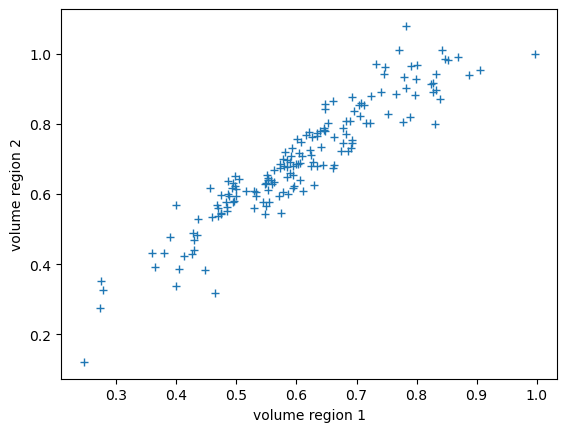

In [6]:
import pandas as pd

#  first load data 
df = pd.read_csv("GA-structure-volumes-preterm.csv",header=None)
structure_volumes = df.values
Features = structure_volumes[:,1:] # volumes - we have 6 features and 164 samples

# plot shared distribution of first 2 features
plt.plot(Features[:,0],Features[:,1],'+')
plt.ylabel('volume region 2')
plt.xlabel('volume region 1')


This shows strong correlation between the two features such that it would not be unreasonable to assume that (allowing for sources of noise) we might approximate one from the other. In other words, all meaningful relationships might be best represented in terms of a single projection $\mathbf{u_1}$:

<img src="imgs/ga_versus_brain_volume_with_comp.png" style="max-width:100%; width: 50%; max-width: none">

Our goal with PCA is to estimate this new basis $\mathbf{u}$, in such as way that the orthogonal projection of data points  onto this sub-space maximises the variance of the projected points. For example, using a simplified dataset with four points, where the original points are represented in orange, the new basis is represented by a red line and the points projected onto this line are in green:

<img src="imgs/simplePCA.png" style="max-width:100%; width: 40%; max-width: none">

Remember that the projection of one vector ($\mathbf{x}$) onto another ($\mathbf{u_1}$) is estimated as 

<img src="imgs/vectorprojection.png" style="max-width:100%; width: 40%; max-width: none">

This can be estimated from the dot product:

$$ \mathbf{x.u_1} = |\mathbf{x}||\mathbf{u_1}|cos \theta $$

Therefore the projection $|\mathbf{x}|cos \theta = \frac{\mathbf{x.u_1}}{ |\mathbf{u_1}|}$ or $\mathbf{x.u_1}$ if $\mathbf{u_1}$ is a unit vector.

Assuming $\mathbf{u_1}$ **is** a unit vector, and out data matrix is demeaned, once projected the variance of the projected data is given by:

$$\frac{1}{n-1}  \mathbf{u_1}^T\mathbf{X}_C^T\mathbf{X}_C\mathbf{u_1}  = \mathbf{u_1^TSu_1} $$

We seek $\mathbf{u_1}$ such that when we project our data onto it, we achieve the maximum variance (spread) of points along it. Thus the derivation of PCA can be found by maximising the projected variance $\mathbf{u_1^TSu_1}$  w.r.t. $\mathbf{u_1}$, whilst constraining any solution to prevent $\mathbf{u_1} \rightarrow \infty$ and instead return a unit vector: $\mathbf{u_1}^T\mathbf{u_1}=1 $. This can be enforced through use of a Lagrange multiplier $\lambda_1$:

$$ \mathbf{u_1^TSu_1} + \lambda_1(1-\mathbf{u_1}^T\mathbf{u_1}) $$

which is maximised by the taking the derivative w.r.t. $\mathbf{u_1}$ to return:

$$  \mathbf{Su_1} - \lambda_1\mathbf{u_1}=0 $$
$$ \rightarrow  \mathbf{Su_1}=\lambda_1\mathbf{u_1} $$

And, this relationship may be taken to higher dimensions by making the assumption that the basis vectors $\mathbf{u_i}$ must be orthogonal and thus uncorrelated with one another:

$$ cov(\mathbf{u_1},\mathbf{u_2})=\mathbf{u_2^TSu_1}= \mathbf{u_2}\lambda_1 \mathbf{u_1} $$

Taking in this additional constraint leads to the following revised Langrangian, maximised by taking the derivative w.r.t $\mathbf{u_2}$

$$ \mathbf{u_2^TSu_2} + \lambda_2(1-\mathbf{u_2}^T\mathbf{u_2}) - \phi\mathbf{u_2}^T\mathbf{u_1} $$

$$  \mathbf{Su_2}-\lambda_2\mathbf{u_2} - \phi\mathbf{u_1} = 0 $$

Left multiplying through by $\mathbf{u_1}$ gives:
$$  \mathbf{u_1^TSu_2}-\lambda_2\mathbf{u_1^Tu_2} - \phi\mathbf{u_1^Tu_1} = 0 $$

where, from above we note that due to orthogonality $\mathbf{u_1^TSu_2}$ and $\lambda_2\mathbf{u_1^Tu_2}$ must equal zero. Thus by definition $\phi\mathbf{u_1^Tu_1}$ must equal zero, see:

$$  \mathbf{u_1^TSu_2}-\lambda_2\mathbf{u_1^Tu_2} - \phi\mathbf{u_1^Tu_1} = 0 $$
$$ \rightarrow 0 - 0 - \phi\mathbf{u_1^Tu_1} = 0$$

Accordingly, as this additional constraint can be shown to be zero, this simply means that $  \mathbf{Su_2}=\lambda_2\mathbf{u_2} $ and the second basis vector $\mathbf{u_2}$ is the second eigenvector of the covariance matrix. 

### A note on Langrangian multipliers (optional)

The above derivation takes a Langrangian approach to constrained optimisation.  This supports estimation the local maxima and minima of a function subject to equality constraints without need for explicit parameterisation of the constraints. 

Specifically for function $f(x)$ and constraints $g(x)$ given problem:
maximise $f(x)$
s.t. $g(x)=0$ 

And instead solve for:
$L(x,\lambda)=f(x) -\lambda g(x)$

In the above example the function is $ \mathbf{u_1Su_1^T} $ and the constraint is $\mathbf{u_1}^T\mathbf{u_1}=1 $. Lagrangian optimisation also appears in support vector machine optimisation

## 4. Estimating PCA eigenvectors from the Covariance matrix

Thus, all principal eigenvectors may be obtained from eigen-decomposition of the mean-centred feature covariance matrix $\mathbf{S}=\frac{1}{n-1} \mathbf{X}_C^T\mathbf{X}_C$, where $\mathbf{X}_C = \mathbf{X} -\mathbf{\bar X}$; 

$\mathbf{X} \in \mathbb{R}^{n\times m}$ (n= number of samples/examples and m =numbers of features) and mean $\mathbf{\bar X} = [\bar x_1, \bar x_2 ... \bar x_m ]$; 

This results in the following eigenvalue equation (in matrix representation):

$\mathbf{SU}=\mathbf{U\Lambda }$,


with $\mathbf{U} \in \mathbb{R}^{m \times m}$ and $\mathbf{\Lambda} \in \mathbb{R}^{m \times m}$; $\mathbf{\Lambda}$ is a diagonal matrix e.g. 

$\mathbf{\Lambda}= \begin{pmatrix} 
\lambda_1 & 0 & 0 & \dots & 0 \\
0 & \lambda_2 & 0 & \dots & 0 \\ 
\vdots & \vdots  &  \vdots  & \ddots  & \vdots  \\ 
0 & 0 & 0 & \dots & \lambda_m \\ 
\end{pmatrix}$

With the PCA basis estimated as eigenvectors $\mathbf{U}$, all data $\mathbf{X}_C$ may be projected into this new basis as $\mathbf{Y} = \mathbf{X}_C\mathbf{U}$. Where the order of multiplication here is specific to the row/column orientation of $\mathbf{X}_C$ (assuming data examples are rows, and columns of $\mathbf{U}$ are the eigenvectors. 


### Exercise 2: Estimating PCA bases from data covariance matrices

Taking the neonatal brain volume data set ('GA-structure-volumes-preterm.csv'), let's first plot volumes against gestational age for each brain region separately (keeping to the first 10 regions for visualisation purposes):

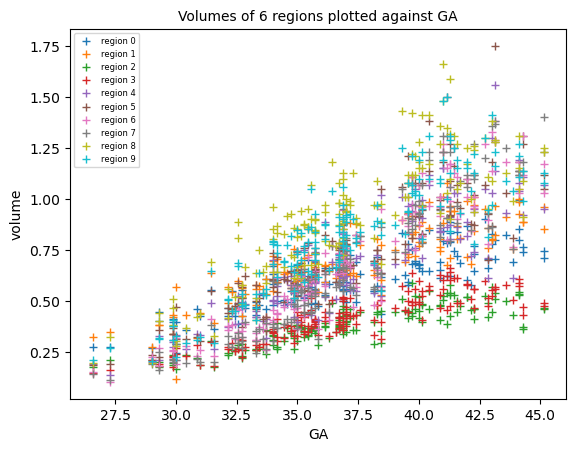

In [7]:
import pandas as pd

#  first load data and separate out the data from the labels
df = pd.read_csv("GA-structure-volumes-preterm.csv",header=None)
structure_volumes = df.values
Features = structure_volumes[:,1:11] # volumes - we have 6 features and 164 samples
Labels = structure_volumes[:,0] # GA - 164 


# now plot the volumes of each region against GA separately

for i in np.arange(Features.shape[1]):
    plt.plot(Labels,Features[:,i],'+',label='region '+ str(i))

plt.title("Volumes of 6 regions plotted against GA",size=10)
plt.ylabel('volume')
plt.xlabel('GA')
plt.legend(prop={'size': 6})


We see that clearly there is high correlation in the growth trends of each region. It seems likely that the data could be better represented by fewer eigenvectors.

Now estimate the PCA eigenspace from the eigenvectors of the data covariance matrix, and use this to project all data into the new basis. In the next window complete the function for estimation of pca from the sample covariance matrix ($\mathbf{S}=\frac{1}{n-1} \mathbf{X}_C^T \mathbf{X}_C$). Replace ```None``` values with correct code so as to :

1.  mean centre the data ($\mathbf{X}_C=\mathbf{X}-\mathbf{\bar X}$)
2.  estimate the data covariance matrix 
3.  Evaluate the eigenvectors and values of the covariance matrix.
4.  Sort eigenvalues and eigenvectors in descending order
5.  Project all data onto the PCA eigenspace 

Test performance by running the code in the cell below.

<details>
  <summary>Click me for hints </summary>
    
Hints: 
 - you may use numpy's mean function (```np.mean(..)```), but check that the dimensionality of your mean vector matches what you expect. Your goal is to estimate the mean and variance of the features (one mean per featurs)
 - Please implement the sample covariance; you can check its accuracy against the output of ```np.cov()```. Covariance should have shape (features,features)
 - For eigenvalue and eigenvectors use numpys linalg.eig(..) function (see Numpy.ipynb and https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html for more details)
 - for sorting consider ```argsort``` this will output the indices for sorting - from which you can then permute both matrices
 - ```argsort``` sorts in ascending order but you want descending order! See https://stackoverflow.com/questions/15748001/reversed-array-in-numpy for clues
    
<details>

In [ ]:
# create function to estimate PCA from covariance matrix
def pca_from_covariance(X):
    
    """
    Function to estimate PCA from sample covariance matrix:
    
    Input args:
        X : data matrix with shape (n_features, n_samples)
        
    Output args:
        u : eigenvectors of the sample covariance matrix
        d : eigenvalues of the sample covariance matrix
        X : centered data
    """
    
    # 2.1.1 estimate mean vector (replace None with correct code)
    # here we are interested in covariance across features
    X_mean=None

    # 2.1.2 mean center 
    X_C=None
    
    # 2.2 estimate data covariance matrix
    # you are looking for (co)variance across features
    S=None

    # 2.3 estimate eigenvalues and vectors using inbuilt numpy functions
    d,u=None
    
    # 2.4 sort eigenvalues and vectors by descending size 
    idx = None  
    
    # idx gives the permutation - which eigenvalues at which locations correpond to the 1,2,3... etc biggest values
    # now you need to apply those to the eigenvalue and eigenmatrix array to permute both into descending order (by eigenvalue)
    # don't forget each eigenvalue is paired to an eigenvector so you must change both!
    d = None 
    u = None
        
    return u,d,X_C

In [ ]:
# perform pca using pca_from_covariance(X)
vecs,vals,X_centered=pca_from_covariance(Features)
print('Eigenvalues are:', vals)
print('Eigenvectore shape :', vecs.shape)

# 2.5 project data 
Y= None
print("Projected coordinates for first data points is: \n {}".format( Y[0]))


## 5. Estimating PCA using Singular Value Decomposition (SVD)

Alternatively PCA eigenvectors and values may be estimated through Singular Value Decomposition (SVD). This decomposition allows spectral (eigen) decomposition of any matrix (including non-square matrices). 

For any $(n \times m)$ matrix $\mathbf{X}_C$, where $m \geq n $ SVD is defined as:

$$ \mathbf{X}_C=\mathbf{U\Lambda V^T}$$

Where, $\mathbf{U} \in \mathbb{R}^{n\times n }$, with orthonormal columns ($\mathbf{U}^T\mathbf{U} = \mathbf{I}$), represents the left singular vectors of matrix $\mathbf{X}_C$; $\mathbf{V} \in \mathbb{R}^{m\times m }$, ($\mathbf{V}^T\mathbf{V} = \mathbf{I})$ represents the right singular vectors of matrix $\mathbf{X}_C$; and $\mathbf{\Lambda} \in \mathbb{R}^{n\times m }$ is a diagonal matrix with positive or zero elements, called the singular values. 

The relationship between PCA and SVD can be seen if we subsitute eq $ \mathbf{X}_C=\mathbf{U\Lambda V^T}$ into our expression for the eigenvectors and values of our covariance matrices (temporarily dropping the $\frac{1}{n-1}$ normalisation term for visualisation purposes):

$$
\begin{align}
\label{eq:SVD}
\mathbf{X}_C\mathbf{X}_C^T \mathbf{U} &=\mathbf{U \Lambda V}^T(\mathbf{U \Lambda V}^T)^T  \mathbf{U} \nonumber\\
&=\mathbf{U \Lambda V}^T\mathbf{V \Lambda U}^T  \mathbf{U} \nonumber\\
&= \mathbf{U \Lambda}^2\mathbf{U}^T  \mathbf{U} \nonumber\\
&= \mathbf{U \Lambda}^2
\end{align}
$$

Thus, $\mathbf{U}$ reflect the eigenvectors of data covariance matrix $\mathbf{X}_C\mathbf{X}_C^T$. Likewise, $\mathbf{V}$ represents the eigenvectors $\mathbf{X}_C^T\mathbf{X}_C$:
$$
\begin{align}
\mathbf{X}_C^T\mathbf{X}_C \mathbf{V} &=(\mathbf{U \Lambda V}^T)^T\mathbf{U \Lambda V}^T \mathbf{V}\nonumber\\ 
&= \mathbf{V \Lambda}^2\mathbf{V}^T  \mathbf{V} \nonumber \\
&= \mathbf{V \Lambda}^2
\end{align}
$$
In both cases, covariance matrices share $r$ non-zero eigenvalues ($\mathbf{\Lambda} \in \mathbb{r \times r}$), where $r$=matrix rank and these are related to the SVD singular values as:
$$
\begin{equation}
    \lambda_i=\frac{\sigma_i^2}{n-1}
\end{equation}
$$
Where, here we have replaced the normalisation term

### Exercise 3

Given the ```Features``` matrix derived from 'GA-structure-volumes-preterm.csv' above, estimate the PCA eigenspace through Singular Value Decomposition (SVD).  Project all data into the new basis (as before).

1. First complete the function ```pca_from_svd``` replacing ```None``` with the correct code. 
2. In the following window apply the function to the data as before (done for you). 
3. Estimate the explained variance (equivalent to the eigenvalues of the covariance matrix) by transforming the singular values
4. Project the data into the new basis and plot the result. Do you need the left singular vectors or the right?

Hints:
- Use https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html


<details>
  <summary>Click me for more hints </summary>
    
Hints: 
 - when deciding on left or right singular vectors consider their shape
 - don't forget that ```np.linalg.svd``` outputs the left singular vectors as columns and the right singular vectors as rows
 - compare against your covarianc eimplementation to check results are the same
    
<details>


In [8]:
# create function to estimate PCA from SVD
def pca_from_svd(X):
    
    """
    Function to estimate PCA through SVD
    
    Input args:
        X : data matrix with shape (n_features, n_samples)
        
    Output args:
        u : left singular vectors 
        d : singular values
        v : right singular vectors
        X : centered data
    """
    # 3.1.1  mean center 
    # as before
    X_C=None

    # 3.1.2 estimate eigenvalues and vectors of X using SVD
    u,d,v=None
   
     
    return u,d,v,X_C

In [ ]:
# 3.2 perform pca using pca_from_svd(X)
leftvecs,vals,rightvecs,X_centered=pca_from_svd(Features)

print(leftvecs.shape,rightvecs.shape,X_centered.shape)
# 3.3. convert singular values to explained variance
lambdas=None

print('SVD singular values are:', vals)
print('Explained Variance  :  {}'.format(lambdas))
print("left singular vectors shape: {}; Right Sungular Vector Shape: {} ".format(leftvecs.shape,rightvecs.shape))

# 3.4 transform data
# you choice to project onto the singular vectors with the length corresponding to the feature dimension
# in this case the right singular vectors correspond to covariance matrix X.TX
Y=None
print("Projected coordinates for first dats point is: \n {}".format( Y[0,:]))



## 6. PCA for dimensionality reduction

For datasets that have more features than examples, the action of projecting all points onto their PCA components  reduces feature dimensionality automatically; since, the total number of non-zero components is *at most* equal to the the size of the smallest dimension of the data matrix (matrix rank $r \leq \min(m,n)$). Often the rank of the data covariance matrix will be even less as a result of correlation between features. For example, in our example of predicting neonatal brain age from the volume of different brain regions, we have already seen strong correlation in the trends of growth for different brain regions. A cumulative distribution of the values of PCA eigenvalues derived from the full data set shows that almost all of the data variance can be described by just 3 eigenvalues. Thus, we could project $\mathbf{X}_C$ onto just 3 eigenvectors and still capture most meaningful variation in the data. Although there is no strict guide, a good rule of thumb is to choose the set of PCA eigenvectors that represent some significant proportion (e.g. 90\%) of the total data variance. 

<img src="imgs/cdf_eigenvalues_cutoff.png" style="max-width:100%; width: 40%; max-width: none">


## 7.  Implementing PCA in Scikit Learn

As with all models, PCA is straightforwardly implemented using a few calls to SciKit Learn. The PCA object is derived from ```class sklearn.decomposition}``` and takes an optional argument  ```n_components```, which determines the number of components that are returned from the model. In the example below we fit PCA to a randomly generated matrix of shape ```(10,2)```. You will see the ``fit`` function takes only data as input (as the model is unsupervised). Some important attributes of the model are the ```explained_variance_ratio_``` (eigenvalues represented as a proportion of the total variance); ```singular_values_``` (singular values) and ```components_``` (the eigenvectors corresponding to the feature dimension of the data matrix).


In [ ]:
from sklearn.decomposition import PCA

# creating a random matrix of shape (10,2)
random_data=np.random.uniform(0,10,(10,2))
print(random_data.shape)
#3.5.1 instantiate and fit model (two lines)
# note that PCA is unsupervised - we use only Features for fitting!
# fill in
model=PCA(n_components=2) #n_components is an optional argument PCA() will return same result here as max dim is 2 for features
# sklearnexpects data matrix with shape (n_samples,n_features) do you need transpose
# remember fit will onlt fit the PCA if you want to project data as well use fit_transform()
model.fit(random_data) 

# get attributes: 1) explained variance (lambdas); 2) singular values (gammas); 3) components
explained_variance=model.explained_variance_ratio_
singular_values=model.singular_values_
components=model.components_

print('Explained variance (lambdas): {}'.format(explained_variance))
print('Singular values (gammas):  {}'.format(singular_values))
print('Principal components: \n {}'.format(components))


### Exercise 4. Use PCA with sklearn for dimensionality reduction

Try out Sci-kit Learn PCA for the purposes of dimensionality reduction on the example from 'GA-structure-volumes-preterm.csv' . This time use all regions.

In the below code cell we estimate performance of multivariate linear regression for prediction of Gestation; age from all features from 'GA-structure-volumes-preterm.csv' (86 regions). We can see that the model has clearly overfitted since the validation performance lags way behind that of the training set. 

In [ ]:
# Multivariate linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


Features = structure_volumes[:,1:] # volumes use all 86 features and 164 samples
Labels = structure_volumes[:,0] # GA - 164 

model = LinearRegression()
model.fit(Features,Labels)
R2_score = model.score(Features,Labels)
cv_score = cross_val_score(model, Features, Labels, cv=5).mean()
 
rmse = np.sqrt(-cross_val_score(model, Features, Labels, cv=5,scoring='neg_mean_squared_error').mean())
print("R2 score is {} and cross-validated R2 score is {}".format(round(R2_score,2), round(cv_score,2)))
print("Cross-validated root mean squared error is {} weeks GA".format(round(rmse,2)))

Implement PCA with scikit learn to reduce the dimensionality of our feature set.

**To do** 

1. Using sklearn fit a PCA model of the data
2. Return the ordered and normalised eigenvalues using PCA attribute ```explained_variance_ratio_```
3. plot the cumulative distribution (this should look like the figure in section 6 above)
4. Try moving the vertical line along the x axis to estimate the optimal cut off. 
5. How much of the variance  is explained by just the first eigenvalue


*Hint:* a cumulative sum can be estimated using the ```np.cumsum()``` function.

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
%matplotlib inline 

# 4.1 create PCA model 
pca = None
# 4.1 fit the data (1 lines)
None

# 4.2 extract explained variance
normalised_values=None 

# 4.3 estimate the cumulative distribution of the explained variance
cumulative_sum=None

# plot the distribution
plt.plot(cumulative_sum)
plt.xticks(np.arange(0,normalised_values.shape[0],5))
plt.title('cumulative distribution of PCA eigenvalues',size=10)
plt.ylabel('cumulative sum')
plt.xlabel('# components')

# 4.4. now select lines parallel to the y-axis 
# play with different values of cutoff to determine a good one
# a good rule of thumb would be where it levels out 
cutoff = 3
x=np.ones(10)*cutoff
y=np.linspace(normalised_values[0],1,10)
plt.plot(x,y)

4.5 #  print out variance described by first
print('The amount of variance explained by just the first eigenvector is {}\%'.format(None))



**To do** 

6. Finally use this cut-off to determine an appropriate cut off for PCA dimensionality reduction. Re-run PCA with this reduced set. For this you need to:
 - rerun PCA with fewer components
 - transform the data by projecting in onto the components (using scikit learn
 - refit the model

*Hint:* use parameter ```n_components```

In [ ]:
# 4.6.1 create PCA model with number of components equal to the chosen cutoff
# fill in this line 
pca = None
# 4.6.2 now fit and transform the data (1 to 2 lines)
None

# check the size of the newFeatures
# see we have moved froman 896 dimensional feaure spacef to just 3 dimensions
print('Size of original features: ', Features.shape)
print('Size of new features: ', newFeatures.shape)

# 4.6.3 refit the linear regression model linear regression using the new features (2 lines)
model_new = None

# 4.6.3 get R2 scores on training data and cross validation performance (2 lines)
R2_score_new = None
cv_score_new = None

# we can see now that we get a better performance a cross our left out validations sets
# this suggests that above a certain range the components encode noise 
print("New model R2 score is {} and cross-validated R2 score is {}".format(round(R2_score_new,2), round(cv_score_new,2)))

# References

[1] Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Vol. 4. No. 4. New York: springer, 2006. (Chapter 1 section 4)